In [13]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as stats

cases = pd.read_csv('covid_confirmed_usafacts.csv')
deaths = pd.read_csv('covid_deaths_usafacts.csv')
population = pd.read_csv('covid_county_population_usafacts.csv')

def statewide_stats(cases, deaths, state_name):
    # Get weekly case and death stats
    weekly_case_stats = state_weekly_stats(cases, state_name)
    weekly_death_stats = state_weekly_stats(deaths, state_name)
    # Combine both stats for the state
    state_county_weekly = pd.concat([weekly_case_stats, weekly_death_stats], axis=1)

    # Create a DataFrame to hold statewide stats
    statewide_weekly_stats = pd.DataFrame()
    
    # Create weekly date ranges for statewide stats
    weekly_groups = pd.date_range(start='2020-06-01', end='2021-01-03', freq='W-SUN')

    for i in range(len(weekly_groups)):
        statewide_mean = weekly_case_stats[f'week_{i+1}_mean'].mean()
        statewide_median = weekly_case_stats[f'week_{i+1}_median'].median()
        statewide_mode = weekly_case_stats[f'week_{i+1}_mode'].mode()[0]

        statewide_death_mean = weekly_death_stats[f'week_{i+1}_mean'].mean()
        statewide_death_median = weekly_death_stats[f'week_{i+1}_median'].median()
        statewide_death_mode = weekly_death_stats[f'week_{i+1}_mode'].mode()[0]

        statewide_weekly_stats = pd.concat([statewide_weekly_stats, pd.DataFrame({
            'Week': [f'{i+1}'],
            'State': [state_name], #Edit, I kept state name column for ID perposes
            'Statewide Case Mean': [statewide_mean],
            'Statewide Case Median': [statewide_median],
            'Statewide Case Mode': [statewide_mode],
            'Statewide Death Mean': [statewide_death_mean],
            'Statewide Death Median': [statewide_death_median],
            'Statewide Death Mode': [statewide_death_mode]
        })], ignore_index=True)

    return statewide_weekly_stats

def state_weekly_stats(dataframe, state_name):
    state_deaths = dataframe[dataframe['State'] == state_name]
    state_columns = state_deaths.iloc[:, :4]
    
    # Select date columns only
    state_deaths_only = state_deaths.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'])
    # Make sure dates are in datetime format
    state_deaths_only.columns = pd.to_datetime(state_deaths_only.columns, format='%Y-%m-%d', errors='coerce')

    state_deaths_only = state_deaths_only.loc[:, (state_deaths_only.columns >= '2020-06-01') & (state_deaths_only.columns <= '2021-01-03')]
    
    # Empty DataFrame to hold stats
    weekly_death_stats = pd.DataFrame()
    
    # Create weekly date ranges
    weekly_groups = pd.date_range(start='2020-06-01', end='2021-01-03', freq='W-SUN')

    # For loop to iterate over weeks and calculate stats for deaths
    for i, week_end in enumerate(weekly_groups):
        # Select the date range for the week
        week_start = week_end - pd.Timedelta(days=6)

        # Select the columns corresponding to the week
        week_columns_deaths = state_deaths_only.loc[:, (state_deaths_only.columns >= week_start) & (state_deaths_only.columns <= week_end)]
        
        # Calculate mean, median, and mode for each county (row) across the week (columns)
        weekly_death_mean = week_columns_deaths.mean(axis=1)
        weekly_death_median = week_columns_deaths.median(axis=1)
        weekly_death_mode = week_columns_deaths.mode(axis=1)[0]  # Pick the first mode 

        # Store the results in the DataFrame
        weekly_death_stats[f'week_{i+1}_mean'] = weekly_death_mean
        weekly_death_stats[f'week_{i+1}_median'] = weekly_death_median
        weekly_death_stats[f'week_{i+1}_mode'] = weekly_death_mode

    weekly_death_stats = pd.concat([state_columns, weekly_death_stats], axis=1)

    
    return weekly_death_stats

def state_population(population, state_name):
    population = population[population['State'] == state_name]
    return population['population'].sum()

# args - num is what you are normalizing by - ex, for per 10,000 people you send in 10000
#      - states is a list of states to plot - ex, states = florida, washington - where florida and washington are DFs
#      - title of graph and y_label of graph - send in as string
def plot_states(num,states, title, y_label,type):
    plt.figure(figsize=(10, 6))
    if (type == 'case'):
        for state in states:
            #before being used, data is sent to get normalized and then it is given to be plotted
            plot = normalize(num,state.loc[:,'Statewide Case Mean'],state.loc[3,'State'])
            #plot and use state abriviation as label
            plot.plot(label = state.iloc[2,1])
    elif (type == 'death'):
        for state in states:
            #before being used, data is sent to get normalized and then it is given to be plotted
            plot = normalize(num,state.loc[:,'Statewide Death Mean'],state.loc[3,'State'])
            #plot and use state abriviation as label
            plot.plot(label = state.iloc[2,1])    
    plt.legend()
    plt.title(title),
    plt.xlabel("Week"),
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.show()

# args - num is what you are normalizing by - ex, for per 10,000 people you send in 10000
#      data is the column of data to be normalized - ex, to normalize the 'Statewide Case Mean' column send in
#      -> state.loc[:,'Statewide Case Mean'] - for this arg. State can be the florida df seen below
#      - Send state abreviation - example, for florida send 'FL'
def normalize(num,data,state):
    pop = state_population(population,state)
    new = (data/pop)*num
    return new

Preparing the data and fitting the normal distribution

In [238]:
def plot_distribution(state_data, state_name):
    data = state_data['Statewide Case Mean']
    mu, std = stats.norm.fit(data)
    x = np.linspace(min(data), max(data), 100)
    fitted_pdf_norm = stats.norm.pdf(x, mu, std)

    plt.figure(figsize=(12, 8)) 
    
    # Plot the histogram of the data and the fitted Normal distribution
    plt.hist(data, bins=18, density=True, alpha=0.6, color='#76c7c0', edgecolor='black', label='Case Data')
    plt.plot(x, fitted_pdf_norm, 'b-', label=f'Fitted Norm Dist (mean={mu:.2f}, Standard Deviation={std:.2f})', linewidth=2)

   
    
    # Add titles and labels
    plt.title(f'{state_name} Fitted Normal Distribution')
    plt.xlabel('Weekly Cases')
    plt.ylabel('Density')
    plt.legend()
   
    plt.show()

In [256]:
florida = statewide_stats(cases, deaths, 'FL')
arkansas = statewide_stats(cases, deaths, 'AR')
colorado = statewide_stats(cases, deaths, 'CO')
oregon = statewide_stats(cases, deaths, 'OR')
south_dakota = statewide_stats(cases, deaths, 'SD')
washington = statewide_stats(cases, deaths, 'WA')

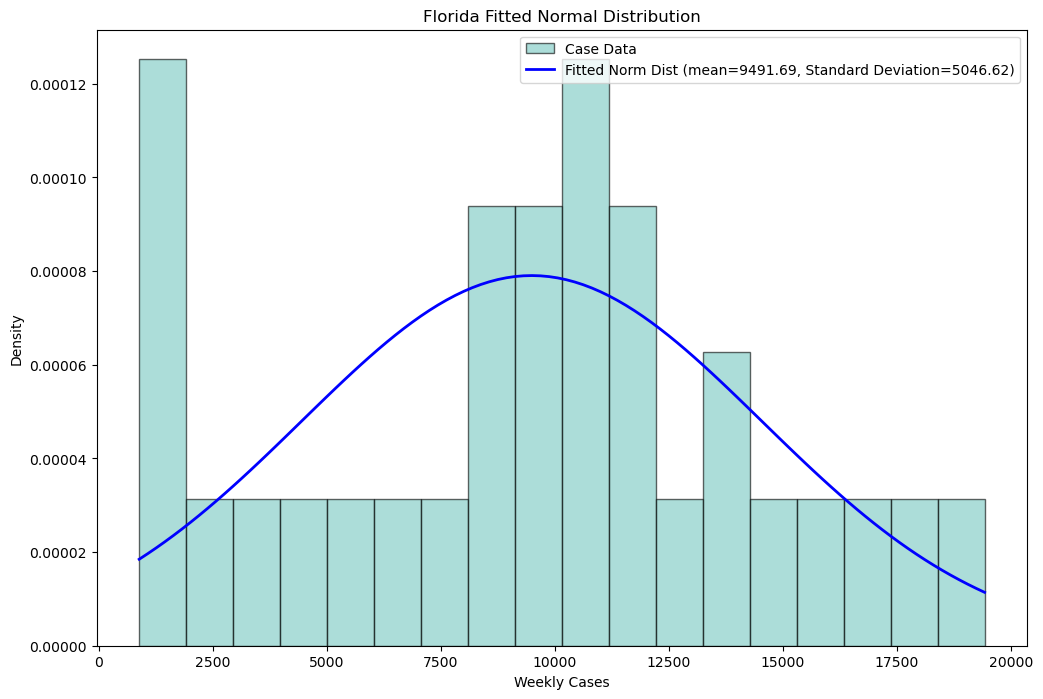

In [258]:
plot_distribution(florida, 'Florida')

In [259]:
skewness = florida['Statewide Case Mean'].skew()
print(f'Skewness: {skewness:.2f}')

Skewness: -0.05


In [260]:
kurtosis = florida['Statewide Case Mean'].kurtosis()
print(f'Kurtosis: {kurtosis:.2f}')

Kurtosis: -0.60


### Destribution Description for Case Data
Destribution Type: Normal Distribution <br>
>Normal Distribution best fits the data provided by the case data witht the exception of the outlier at the begginning

Mean: 9491 cases
>Our mean indicates that the most likely value in our distribution is 9491

Variance: 5046.62
>The varience indicated that most of our data is concentrated 5046 cases above or below the mean.<br>
our high varience also indicated that there the number of new cases varied significantly week by week

Skewness: -.05
>The slight negative skew indicates that there is a slight tail to the left of our data.<br>
The slight negative skew also suggests that there were slightly more weeks with lower case counts than high ones.<br>
Though it is important to point out that it is only a slightly longer tail and not anything significant.

Kurtosis: -.60
>A value less than 3, especially ours which is negative, suggest that our data is more evenly spread with flatter tails.<br>
Kurtosis also suggests that our data has fewer extreme values and our data is concentrated around our mean.

In [276]:
skewness = arkansas['Statewide Case Mean'].skew()
print(f'Skewness: {skewness:.2f}')

Skewness: 0.73


In [278]:
kurtosis = arkansas['Statewide Case Mean'].kurtosis()
print(f'Kurtosis: {kurtosis:.2f}')

Kurtosis: -0.39


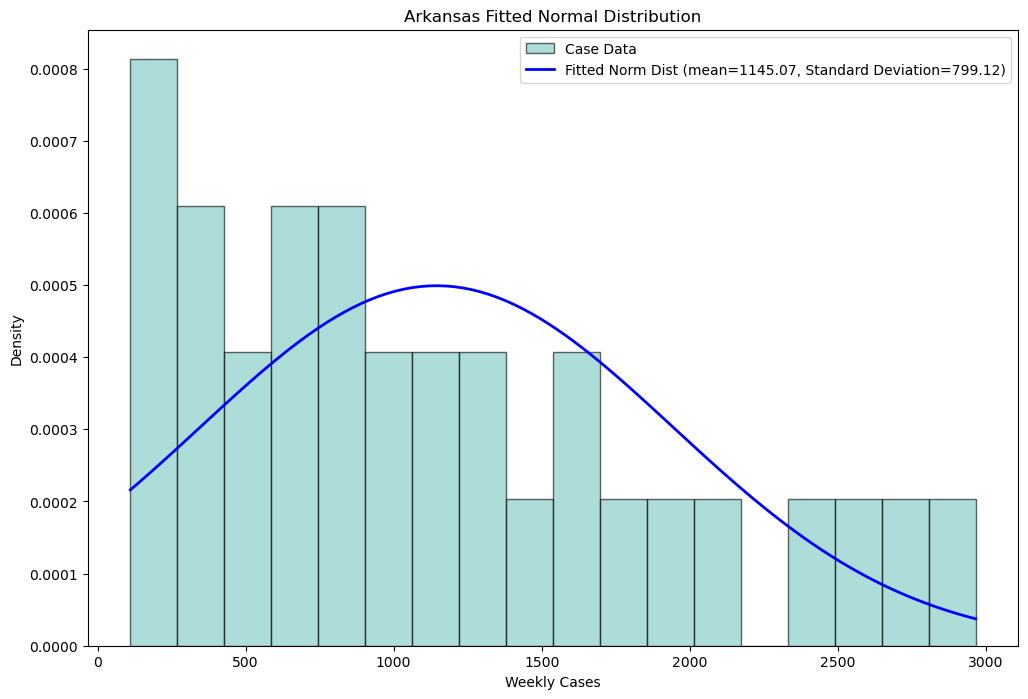

In [266]:
plot_distribution(arkansas, 'Arkansas')

In [282]:
skewness = colorado['Statewide Case Mean'].skew()
print(f'Skewness: {skewness:.2f}')
kurtosis = colorado['Statewide Case Mean'].kurtosis()
print(f'Kurtosis: {kurtosis:.2f}')

Skewness: 1.35
Kurtosis: 0.47


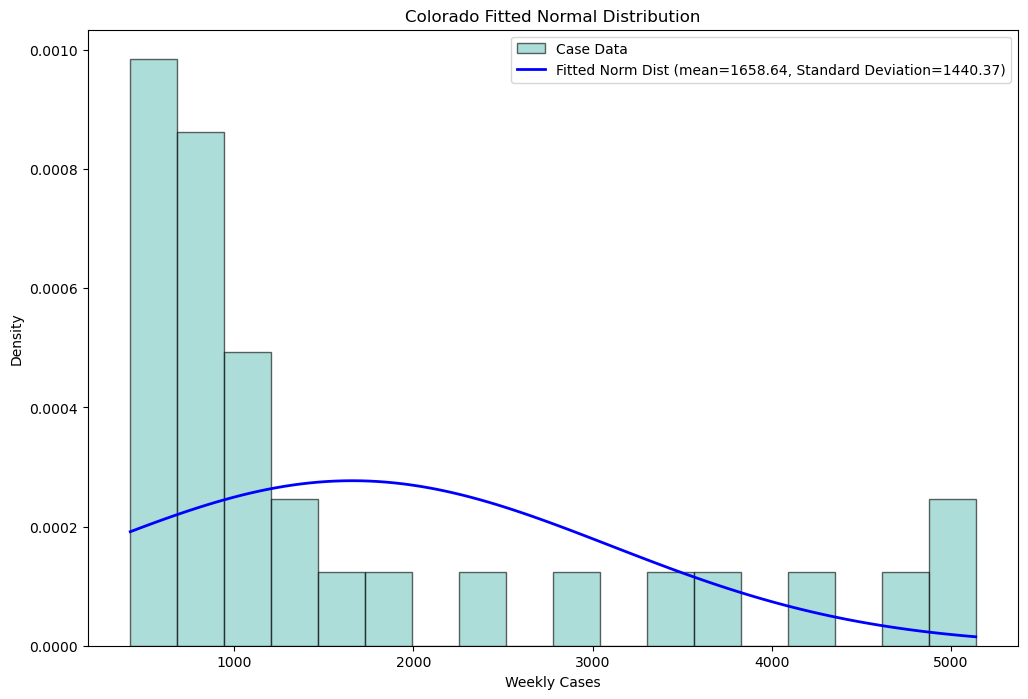

In [268]:
plot_distribution(colorado, 'Colorado')

In [284]:
skewness = oregon['Statewide Case Mean'].skew()
print(f'Skewness: {skewness:.2f}')
kurtosis = oregon['Statewide Case Mean'].kurtosis()
print(f'Kurtosis: {kurtosis:.2f}')

Skewness: 1.07
Kurtosis: 0.25


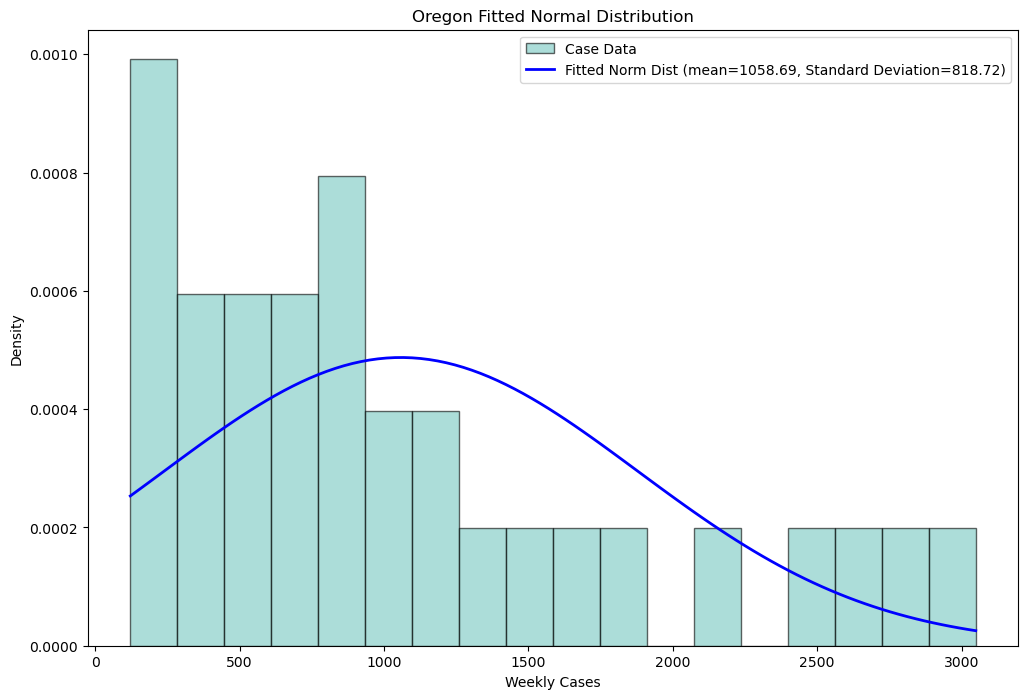

In [270]:
plot_distribution(oregon, 'Oregon')

In [286]:
skewness = south_dakota['Statewide Case Mean'].skew()
print(f'Skewness: {skewness:.2f}')
kurtosis = south_dakota['Statewide Case Mean'].kurtosis()
print(f'Kurtosis: {kurtosis:.2f}')

Skewness: 0.95
Kurtosis: -0.65


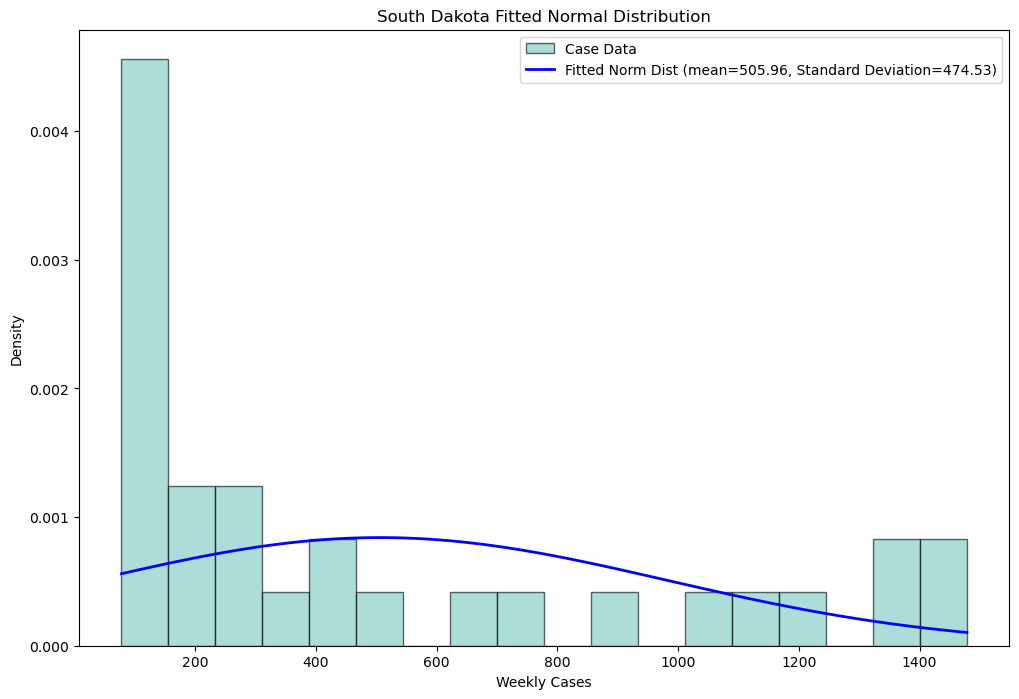

In [271]:
plot_distribution(south_dakota, 'South Dakota')

In [288]:
skewness = washington['Statewide Case Mean'].skew()
print(f'Skewness: {skewness:.2f}')
kurtosis = washington['Statewide Case Mean'].kurtosis()
print(f'Kurtosis: {kurtosis:.2f}')

Skewness: 1.01
Kurtosis: 0.25


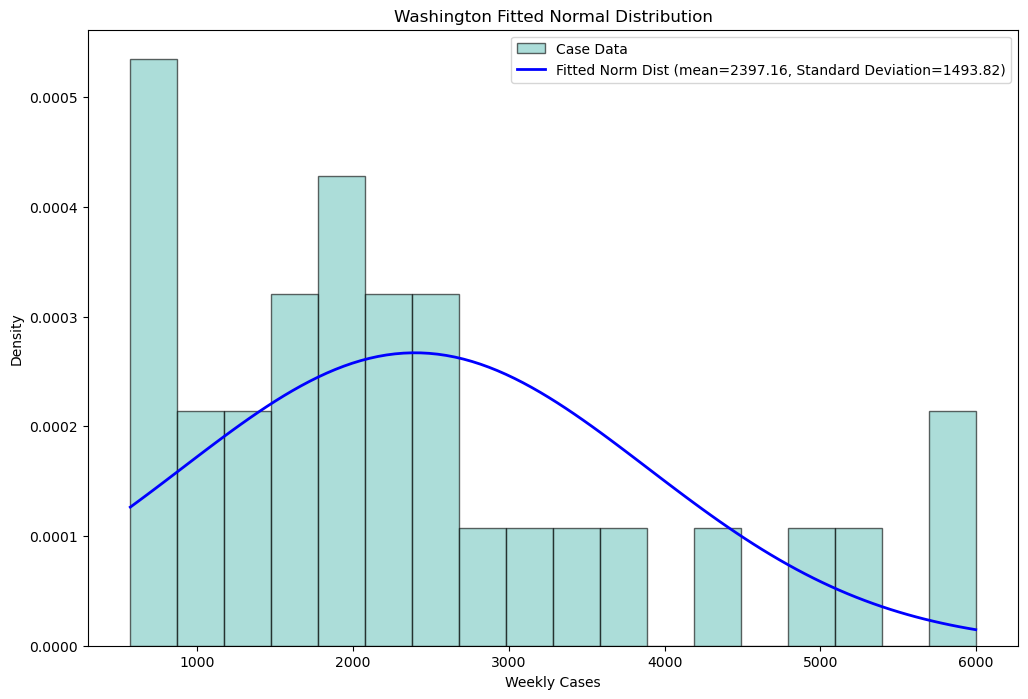

In [273]:
plot_distribution(washington, 'Washington')

### Comparison Against states
Other states compared to Florida:
>All other states resembled more of a log-normal distribution

Arkansas:
>Had a clearer skew which was also positive. Indicating more weeks with higher case counts than lows. Indicating things worsened relatively as time passed.

Colorado: 
>Heavy positive skew with a low kurtosis indicating that Colorado has more weeks with low to moderate case counts with some higher case counts as time passed causing a positive skew.

Oregon: 
>High positive skew with low kurtosis. While the total amount of cases centered around 1058, there was an increase into the 3000s. All this indicates that most weeks has lower case counts and spikes led to the skew.

South Dakota: 
>High positive skew with low negative kurtosis. The mean of 505 was far from the peak indicating that there is a heavy positive skew. There is also an uneven spread of cases suggested by the skew and outliers

Washington: 
>Positive high skew with low positive kurtosis. The mean is 2397 which is near the second peak. Overall the data suggests more weeks with lower case counts with a heavy tail on the right side brought by the spikes in high case counts.